In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from joblib import Memory
from scipy.sparse import hstack

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.sparse import save_npz
import os

In [3]:
# Set up memory caching
memory = Memory('./cachedir', verbose=0)

In [4]:
cwd = os.getcwd()
cwd

'f:\\Studies\\Projects\\ML_Projects\\RealFakeJobPostingPrediction\\src'

## Given:
### [Real or Fake] : Fake Job Description Prediction
### This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

## Goal:
### Create a classification model that uses text data features and meta-features and predict which job description are fraudulent or real.

## Load and Analyze the data:

In [5]:
df = pd.read_csv("../data/raw/fake_job_postings.csv", index_col=0)
description_df = df.copy()
df_combined_text = df.copy()


df.head()


,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  fraudulen

In [7]:
df.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [8]:
df.shape

(17880, 17)

In [9]:
# Count the occurrences of 0 and 1 in the 'fraudulent' column
fraudulent_counts = df['fraudulent'].value_counts()
fraudulent_counts



fraudulent
0    17014
1      866
Name: count, dtype: int64

<Axes: xlabel='fraudulent', ylabel='count'>

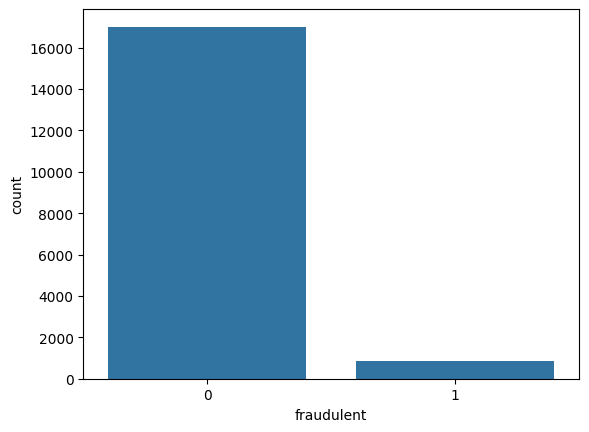

In [10]:
sns.countplot(x = "fraudulent" , data = df)

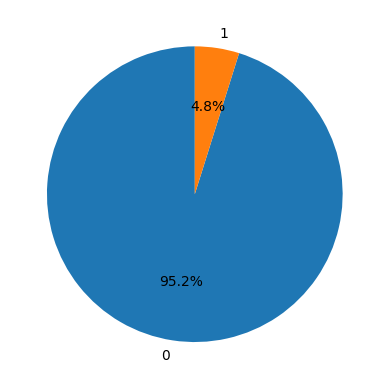

In [11]:
counts = df['fraudulent'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

## Handle Missing Values

In [12]:
# Checking the percentage of nan values in each column:
((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)

salary_range           83.959732
department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
location                1.935123
description             0.005593
title                   0.000000
telecommuting           0.000000
has_questions           0.000000
has_company_logo        0.000000
fraudulent              0.000000
dtype: float64

In [13]:

#Drop the columns salary_range and department
df = df.drop(['salary_range','department'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   company_profile      14572 non-null  object
 3   description          17879 non-null  object
 4   requirements         15184 non-null  object
 5   benefits             10668 non-null  object
 6   telecommuting        17880 non-null  int64 
 7   has_company_logo     17880 non-null  int64 
 8   has_questions        17880 non-null  int64 
 9   employment_type      14409 non-null  object
 10  required_experience  10830 non-null  object
 11  required_education   9775 non-null   object
 12  industry             12977 non-null  object
 13  function             11425 non-null  object
 14  fraudulent           17880 non-null  int64 
dtypes: int64(4), object(11)
memory usage: 2.2+ MB


In [14]:
# drop rows with missing 'description'
df.dropna(subset=['description'], inplace=True)

## Define data types

In [15]:
df.nunique().sort_values()

telecommuting              2
has_company_logo           2
fraudulent                 2
has_questions              2
employment_type            5
required_experience        7
required_education        13
function                  37
industry                 131
company_profile         1709
location                3105
benefits                6204
title                  11231
requirements           11967
description            14801
dtype: int64

In [16]:
data = df['benefits'].value_counts()


# Display Series with index stripped to 80 characters
padded_index = data.index.to_series().str.slice(0,80)
display_df = pd.DataFrame(data.values, index=padded_index)
display_df

,0
benefits,
See job description,726
Career prospects.,158
CSD offers a competitive benefits package for full-time employees. For a full li,70
Our company offers a competitive salary plus BONUSES as well as a comprehensive,60
Plenty of perksAs well as the opportunity to solve complex problems in this exci,58
...,...
We offer: • Excellent training and development opportunities • Excellent Pay Sc,1
"Upon completion of training, each representative will trade firm capital and kee",1
The salary package is $50-$70 K p.a. plus super and incentives.,1


In [17]:
ordinal = [
    'required_experience',
    'required_education',
    'employment_type'
] # Ordinal/Label Encoder

binary = ['telecommuting','has_company_logo','has_questions','fraudulent']

nominal = ['function','industry','location','benefits'] # One-hot encoder / Target Encoder


text    = [
    'description',
    'company_profile',
    'title',
    'requirements'
] # TF-IDF

In [18]:
#get numerical columns:
numerical_colums = df.select_dtypes(include=['number']).columns.tolist()
print(numerical_colums)

['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']


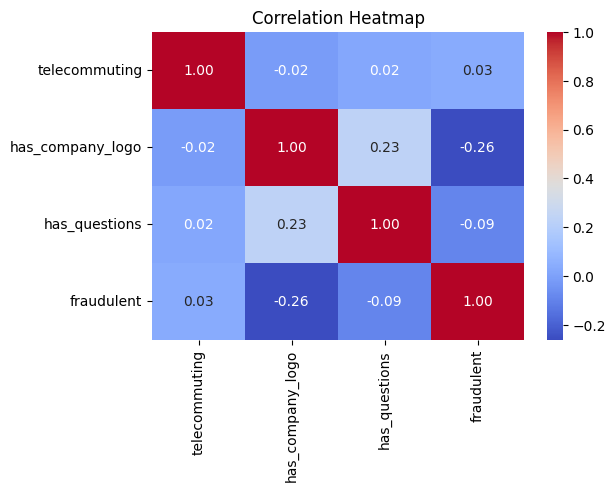

In [19]:
correlation = df[numerical_colums].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Impute missing values

In [20]:
# Get list of columns with missing values
missing_values_columns = df.columns[df.isna().sum() != 0].tolist()
missing_values_columns

['location',
 'company_profile',
 'requirements',
 'benefits',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

In [21]:
# Impute categorical and text columns with placeholders
placeholder_map = {
    'location': 'Other',
    'company_profile': 'Missing',
    'requirements': 'Missing',
    'benefits':'See job description', # mode
    'employment_type':'Other',
    'required_experience': 'Not Applicable',
    'required_education':'Unspecified',
    'industry':'Other',
    'function': 'Other'
}

df.fillna(value=placeholder_map, inplace=True)

In [22]:
df.isna().sum()

title                  0
location               0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

## Encode Categorical Variables


In [23]:
#Encode Ordinal columns using Label Encoding
ordinal_encoder = LabelEncoder()
for column in ordinal:
    df[column] = ordinal_encoder.fit_transform(df[column])



In [24]:
#Encode Nominal columns using Frequency Encoding
def frequency_encode(df, nominal):
    for column in nominal:
        # Calculate frequency of each category
        frequency = df[column].value_counts() / len(df)
        # Map frequencies to the column
        df[column] = df[column].map(frequency)
    return df

df = frequency_encode(df, nominal)



## Separate Features and Target

In [25]:
# use all columns, except fraudulent
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']


## Text Data Cleaning:


In [26]:
# Download required data if not already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lzy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lzy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lzy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:

# Create a lemmatizer and load stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Define a function to lemmatize a column
def lemmatize_column(column):
    if column.dtype != 'object':
        return column
    else:
        lemmas = []
        for token in column:
            if pd.notnull(token):
                # Remove punctuation
                text = ''.join(char for char in token if char not in string.punctuation)
                # Convert to lowercase
                text = text.lower()
                # Split into tokens
                tokens = token.split()
                # Remove stop words
                filtered_tokens = [token for token in tokens if token not in stop_words]
                # Lemmatize tokens
                lemmas.append(' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens]))
            else:
                lemmas.append(None)
        return pd.Series(lemmas)
    
    # Not in use because the model performs better with a simpler text preprocessing function

    

In [28]:
# Simpler text preprocessing function
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9_\s]', '', text)
        text = text.lower()
        text = text.strip()
    return text

In [29]:
text

['description', 'company_profile', 'title', 'requirements']

In [30]:
#Cleaning the text columns
for column in text:
    X[column] = X[column].apply(clean_text)
    

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17879 entries, 1 to 17880
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                17879 non-null  object 
 1   location             17879 non-null  float64
 2   company_profile      17879 non-null  object 
 3   description          17879 non-null  object 
 4   requirements         17879 non-null  object 
 5   benefits             17879 non-null  float64
 6   telecommuting        17879 non-null  int64  
 7   has_company_logo     17879 non-null  int64  
 8   has_questions        17879 non-null  int64  
 9   employment_type      17879 non-null  int64  
 10  required_experience  17879 non-null  int64  
 11  required_education   17879 non-null  int64  
 12  industry             17879 non-null  float64
 13  function             17879 non-null  float64
dtypes: float64(4), int64(6), object(4)
memory usage: 2.0+ MB


### TF-IDF vectorization
 - Define the TF-IDF vectorization function

In [35]:
# Define the TF-IDF vectorization function
@memory.cache                                                         
def fit_and_transform_tfidf(X, features):                                               
    # Initialize vectorizers for each text feature
    vectorizers = {
        feature: TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 2))
        for feature in features
    }

    # List to store TF-IDF matrices
    tfidf_matrices_X = []
    

    # Loop through features to fit and transform
    for feature in features:
        # Fit on  data and transform data
        vectorizers[feature].fit(X[feature])
        tfidf_matrix_X= vectorizers[feature].transform(X[feature])
       

        tfidf_matrices_X.append(tfidf_matrix_X)
        

    
    
    # Combine all TF-IDF matrices into one
    X_text_features = hstack(tfidf_matrices_X)
    

    return X_text_features, vectorizers

 

# Fit and transform the TF-IDF vectors (this will be cached)
X_text_features, vectorizers, = fit_and_transform_tfidf(X, text)


                                                                 

In [36]:
vectorizers


{'description': TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2), stop_words='english'),
 'company_profile': TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2), stop_words='english'),
 'title': TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2), stop_words='english'),
 'requirements': TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2), stop_words='english')}

### Split the data

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_text_features, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
# Save the vectorizers
joblib.dump(vectorizers, 'tfidf_vectorizers.joblib')

['tfidf_vectorizers.joblib']

In [38]:
# check for imbalaced dataset - calculate percentages:
y_train_counts = y_train.value_counts()
percentages = (y_train_counts/y_train_counts.sum())*100
percentages

fraudulent
0    95.161854
1     4.838146
Name: count, dtype: float64

### Oversampling because the dataset is imbalanced

In [39]:
# Creating an instance of SMOTE
smote = SMOTE()

# Balancing the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(X_resampled.shape)
print(y_resampled.shape)

(27222, 170285)
(27222,)


In [40]:
# check for imbalaced dataset - calculate percentages:
y_resampled_counts = y_resampled.value_counts()
percentages = (y_resampled_counts/y_resampled_counts.sum())*100
percentages

fraudulent
0    50.0
1    50.0
Name: count, dtype: float64

## Save the dataset

In [645]:

# Save the sparse matrix
save_npz('../data/processed/X_resampled.npz', X_resampled)

# Save y_resampled as a Series (you can also use Series)
pd.Series(y_resampled).to_csv('../data/processed/y_resampled.csv', index=False)

# Save X_test as a sparse matrix (you can also use Series)
save_npz('../data/processed/X_test.npz', X_test)

# Save y_test as a Series (you can also use Series)
pd.Series(y_test).to_csv('../data/processed/y_test.csv', index=False)
